<a href="https://colab.research.google.com/github/Nzaya/Job-Placement-Scoring-System/blob/master/Copy_of_Recommend_er_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QUESTION

We have a dataset of candidates who applied to various technical roles at Company X. We want to know the best-matched candidates for each of the job roles. Add a scoring system for every candidate on how best he/she matches to a given job role.

In [0]:
# importing files
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests
from io import StringIO
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

#Libraries for reading resumes
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

In [3]:
company_x = 'https://drive.google.com/file/d/1FHU709IpRtgg1LYeOn7P9AAwMNdxeMqG/view?usp=sharing'

def read_csv(url):
  url = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
  csv_raw = requests.get(url).text
  csv = StringIO(csv_raw)
  return csv

  # Loading the dataset
df = pd.read_csv(read_csv(company_x), encoding = 'utf-8')
df.head()


,Candidate Id,Location,Current Annual Salary,Current Salary Currency,Current Salary Type,Expected Annual Salary,Expected Salary Currency,Total Experience in years,Current Industry,Current Fuction,Relocation Cities,Notice Period in days,Current Job Title,Data Source
0,A13380,NCR,NaN,NaN,ANNUAL,60.0,INR,9.00,"Banking,Financial Services,Broking",NaN,NaN,NaN,Team Manager Insurance,INDEED.COM
1,A9339,Vadodara,8.0,INR,ANNUAL,8.0,INR,3.00,Energy and Utilities | Telecommunications#Manu...,Business Development#Manufacturing#Project Man...,NaN,30.0,Marketing Executive,INTERNAL DATABASE
2,A10220,Noida,11.0,INR,ANNUAL,11.0,INR,0.70,IT | Computer Software#Manufacturing | Mechani...,IT Software,NaN,90.0,Software Developer,INTERNAL DATABASE
3,A8162,Hyderabad,8.0,INR,ANNUAL,8.0,INR,3.84,"IT | Information Services, IT | Computer Software","Business Development, IT Software",NaN,90.0,Senior systems engineer,LINKEDIN
4,A13729,Hyderabad,9.6,NaN,ANNUAL,11.0,INR,2.50,IT | Computer Software,IT Software#Research,NaN,30.0,Software Developer,LINKEDIN


In [4]:
job_details = 'https://drive.google.com/file/d/142EBRBGiLl6iTELhQW9a1c7xvMmfXYtp/view?usp=sharing'

job = pd.read_csv(read_csv(job_details))
job

,Job Id,Job Title,Keywords,Minimum Experience in years,Maximum Experience in Years,Minimum Annual Salary,Maximum Annual Salary,Currency,Must Haves,Company Name,Founded Year,Employee Count,Job Location,Industry,Function,Required Education (UG),Required Education (PG),Notice Period (Days)
0,194,Full stack engineer,"java,Angular,Jquery,j2ee,microservices,micro s...",2,5,6,15,INR,NaN,Company X,2011,362,Hyderabad,IT | Computer Software,IT Software,B.Tech/B.E.,NaN,60
1,481,Senior Java Engineer/Tech Lead,"J2EE,Java,Hibernate,Webervices,REST Services,S...",7,10,10,15,INR,Should have proficient Java server side progra...,Company X,2011,362,Hyderabad,IT | Computer Software,IT Software,Other UG,Not Required,30
2,839,Front End Developer,NaN,2,5,4,8,INR,The candidate must have at least 2 years of so...,Company X,2011,362,Bengaluru/Bangalore,IT | Information Technology and Services,IT Software,Undergraduate (engineering),NaN,30
3,723,Application Developer,"c#, asp.net, sql, java, html5",3,8,4,9,INR,The Application Developer is a role within the...,Company X,2011,362,Bengaluru,IT | Information Technology and Services,IT Software,B.Tech/B.E.,NaN,30


# Data Exploration

In [5]:
# Checking information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7006 entries, 0 to 7005
Data columns (total 14 columns):
Candidate Id                 7006 non-null object
Location                     6924 non-null object
Current Annual Salary        5319 non-null float64
Current Salary Currency      3601 non-null object
Current Salary Type          7005 non-null object
Expected Annual Salary       5891 non-null float64
Expected Salary Currency     6429 non-null object
Total Experience in years    6481 non-null float64
Current Industry             7006 non-null object
Current Fuction              5763 non-null object
Relocation Cities            202 non-null object
Notice Period in days        4154 non-null float64
Current Job Title            6564 non-null object
Data Source                  7006 non-null object
dtypes: float64(4), object(10)
memory usage: 766.4+ KB


In [6]:
# Checking for statical information

df.describe()

,Current Annual Salary,Expected Annual Salary,Total Experience in years,Notice Period in days
count,5319.000000,5891.000000,6481.000000,4154.000000
mean,54.564982,51.515999,5.737999,38.980501
std,2754.707709,2617.848718,4.456510,26.273522
min,0.000000,0.000000,0.000000,0.000000
25%,5.000000,5.000000,2.500000,15.000000
50%,7.500000,7.600000,4.500000,30.000000
75%,12.000000,12.000000,8.000000,60.000000
max,200000.000000,200000.000000,40.980000,90.000000


In [7]:
# Checking for unique  values

for i in df.columns:
  print(i)
  print(df[i].nunique())
  print(df[i].unique())
  print('\n')

Candidate Id
7006
['A13380' 'A9339' 'A10220' ... 'A14152' 'A13986' 'A11843']


Location
330
['NCR' 'Vadodara' 'Noida' 'Hyderabad' 'Bengaluru/Bangalore' 'Bengaluru'
 'Kolkata' 'Mumbai' 'Jabalpur' 'Jaipur' 'Chennai' 'Bangalore' 'New Delhi'
 'Vellore' 'Gurgaon' 'Mandsaur' 'Delhi' 'Lucknow' 'bhubaneswar' 'Srinagar'
 'Kalyan-Dombivali' 'Gadwal' 'Thiruvananthapuram' 'Bobbili'
 'Hyderabad, Secunderabad' 'Bhubaneswar' 'Pune' 'Surat'
 'Anywhere in south' 'Navi Mumbai' 'Coimbatore' 'Tumkur' 'Mysore'
 'gurgaon' 'Bharuch' nan 'Morinda, India' 'Anywhere in north' 'Indore'
 'mumbai' 'hyderabad' 'Kakinada' 'Sivaganga' 'Ranchi' 'Ahmedabad'
 'Dibrugarh' 'JAIPUR' 'Anywhere in east' 'Faridabad' 'Cali' 'BHOPAL'
 'Patna' 'Nagpur' 'India' 'Mangaluru' 'Thane' 'Udaipur' 'Bhavnagar'
 'Athi River' 'Vijayawada' 'Bokaro Steel City' 'Jalore Rajasthan'
 'navi Mumbai' 'Hyderabad , Secunderabad' 'Nashik' 'Bhopal' 'Banglore'
 'Kullu' 'jaipur' 'Guwahati' 'Palakkad' 'Meerut' 'Ghaziabad' 'Goa'
 'Allahabad' 'Adalaj' 'Acha

# Data Cleaning

## Uniformity of columns

In [8]:
# Making the columns to be uniform by removing spaces and converting it to lower

df.columns = df.columns.str.lower().str.replace(' ','_')
df.columns

Index(['candidate_id', 'location', 'current_annual_salary',
       'current_salary_currency_', 'current_salary_type',
       'expected_annual_salary', 'expected_salary_currency',
       'total_experience_in_years', 'current_industry', 'current_fuction',
       'relocation_cities_', 'notice_period_in_days', 'current_job_title',
       'data_source'],
      dtype='object')

## Dealing with missing values

In [9]:
# Checking for missing values

df.isnull().sum()

candidate_id                    0
location                       82
current_annual_salary        1687
current_salary_currency_     3405
current_salary_type             1
expected_annual_salary       1115
expected_salary_currency      577
total_experience_in_years     525
current_industry                0
current_fuction              1243
relocation_cities_           6804
notice_period_in_days        2852
current_job_title             442
data_source                     0
dtype: int64

In [0]:

list1 = ['location','current_job_title']
for i in list1:
  df[i].fillna('unknown',inplace=True)

In [0]:
df['expected_salary_currency'] = df['expected_salary_currency'].replace({'KSh': 'KSH', 'undefined#undefined': 'UNKNOWN'})
df['expected_salary_currency'] = df['expected_salary_currency'].replace(to_replace = np.nan, value = 'UNKNOWN')

In [0]:
df['current_salary_currency_'] = df['current_salary_currency_'].replace({'KSh': 'KSH', 'undefined#undefined': 'UNKNOWN'})
df['current_salary_currency_'] = df['current_salary_currency_'].replace(to_replace = np.nan, value = 'UNKNOWN')

In [13]:
df['current_salary_currency_'].unique()

array(['UNKNOWN', 'INR', 'USD', 'KSH'], dtype=object)

In [14]:
df['expected_salary_currency'].unique()

array(['INR', 'UNKNOWN', 'USD', 'KSH'], dtype=object)

In [0]:
df['current_fuction'] = df['current_fuction'].fillna(df['current_fuction'].mode()[0])

In [0]:
list2  = ['expected_annual_salary','current_annual_salary']
for i in list2:
  df[i] = df[i].fillna(df[i].mean())

In [0]:
df['notice_period_in_days'] =df['notice_period_in_days'].fillna(30)

In [0]:
df['total_experience_in_years'] =df['total_experience_in_years'].fillna(0)

In [19]:
df['current_salary_type'].value_counts()

ANNUAL     6963
MONTHLY      42
Name: current_salary_type, dtype: int64

In [0]:
df['current_salary_type'] = df['current_salary_type'].fillna('ANNUAL')

In [0]:
# Checking the uniformity of the names

df.drop('relocation_cities_',axis=1,inplace=True)

In [22]:
#Rechecking the null values

df.isnull().sum()

candidate_id                 0
location                     0
current_annual_salary        0
current_salary_currency_     0
current_salary_type          0
expected_annual_salary       0
expected_salary_currency     0
total_experience_in_years    0
current_industry             0
current_fuction              0
notice_period_in_days        0
current_job_title            0
data_source                  0
dtype: int64

In [23]:
# Checking for duplicates

df.duplicated().any()

False

There are no duplicates

In [24]:
#Checking the columns

df.columns

Index(['candidate_id', 'location', 'current_annual_salary',
       'current_salary_currency_', 'current_salary_type',
       'expected_annual_salary', 'expected_salary_currency',
       'total_experience_in_years', 'current_industry', 'current_fuction',
       'notice_period_in_days', 'current_job_title', 'data_source'],
      dtype='object')

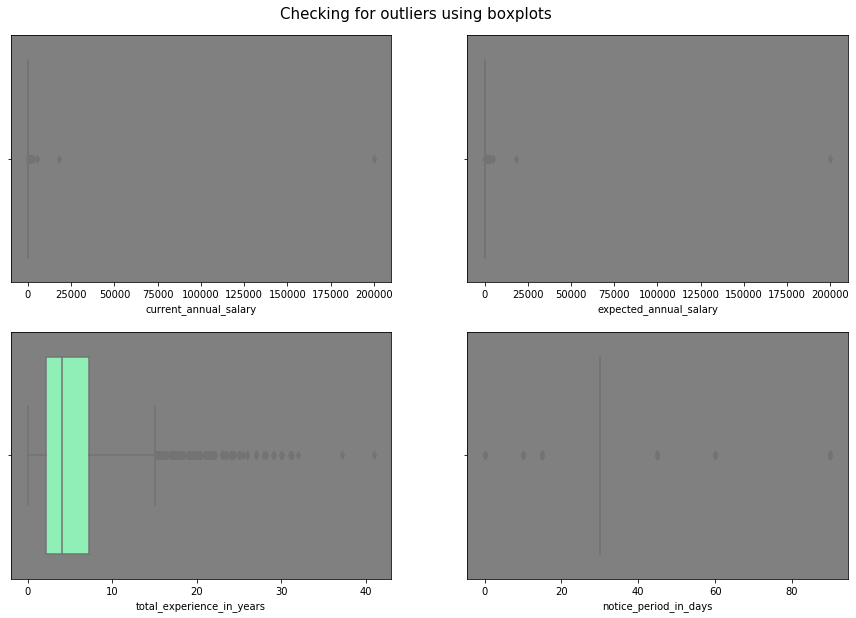

In [25]:
# Checking for outliers

numerical = ['current_annual_salary','expected_annual_salary','total_experience_in_years','notice_period_in_days']
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
plt.suptitle('Checking for outliers using boxplots', fontsize = 15, y = 0.92)
for ax, data, column in zip(axes.flatten(), df, numerical):
  sns.boxplot(df[column], ax = ax,palette = 'rainbow')
  ax.set_facecolor('grey')

There exist several outliers.

Which we shall keep so that we identify the reason for exsistence

In [26]:
# Checking multicollinerity

correlation = df.corr()
pd.DataFrame(np.linalg.inv(correlation),index =correlation.index,columns=correlation.columns)

,current_annual_salary,expected_annual_salary,total_experience_in_years,notice_period_in_days
current_annual_salary,5927.682840,-5927.152457,2.118413,3.342185
expected_annual_salary,-5927.152457,5927.622294,-2.105042,-3.342289
total_experience_in_years,2.118413,-2.105042,1.004039,-0.054648
notice_period_in_days,3.342185,-3.342289,-0.054648,1.004993


There is high multicollinearity between current annual salary and expected annual salary so we have to drop one...preferably the expected annual salary

In [0]:
#Dropping the expected annual salary column

df.drop('expected_annual_salary',inplace=True,axis=1)

In [28]:
# Checking multicollinerity after dropping the expected annual salary

correlation = df.corr()
pd.DataFrame(np.linalg.inv(correlation),index =correlation.index,columns=correlation.columns)

,current_annual_salary,total_experience_in_years,notice_period_in_days
current_annual_salary,1.000184,0.013538,0.000161
total_experience_in_years,0.013538,1.003291,-0.055835
notice_period_in_days,0.000161,-0.055835,1.003108


It is clear that now the variance inflation factor is within range

In [0]:
# Dropping the Current Industry column

df.drop('current_industry', inplace= True, axis=1)

# Explorative Data Analysis

In [30]:
#Creating a dataferame with the relevant columns

new=  df[['candidate_id','current_fuction','current_job_title','total_experience_in_years','data_source']]
data= pd.DataFrame(new)
data.head()

,candidate_id,current_fuction,current_job_title,total_experience_in_years,data_source
0,A13380,IT Software,Team Manager Insurance,9.00,INDEED.COM
1,A9339,Business Development#Manufacturing#Project Man...,Marketing Executive,3.00,INTERNAL DATABASE
2,A10220,IT Software,Software Developer,0.70,INTERNAL DATABASE
3,A8162,"Business Development, IT Software",Senior systems engineer,3.84,LINKEDIN
4,A13729,IT Software#Research,Software Developer,2.50,LINKEDIN


In [31]:
# Previewing the job dataset

job

,Job Id,Job Title,Keywords,Minimum Experience in years,Maximum Experience in Years,Minimum Annual Salary,Maximum Annual Salary,Currency,Must Haves,Company Name,Founded Year,Employee Count,Job Location,Industry,Function,Required Education (UG),Required Education (PG),Notice Period (Days)
0,194,Full stack engineer,"java,Angular,Jquery,j2ee,microservices,micro s...",2,5,6,15,INR,NaN,Company X,2011,362,Hyderabad,IT | Computer Software,IT Software,B.Tech/B.E.,NaN,60
1,481,Senior Java Engineer/Tech Lead,"J2EE,Java,Hibernate,Webervices,REST Services,S...",7,10,10,15,INR,Should have proficient Java server side progra...,Company X,2011,362,Hyderabad,IT | Computer Software,IT Software,Other UG,Not Required,30
2,839,Front End Developer,NaN,2,5,4,8,INR,The candidate must have at least 2 years of so...,Company X,2011,362,Bengaluru/Bangalore,IT | Information Technology and Services,IT Software,Undergraduate (engineering),NaN,30
3,723,Application Developer,"c#, asp.net, sql, java, html5",3,8,4,9,INR,The Application Developer is a role within the...,Company X,2011,362,Bengaluru,IT | Information Technology and Services,IT Software,B.Tech/B.E.,NaN,30


In [32]:
#Creating a dataframe with relevant columns

new=  job[['Job Id','Job Title','Keywords','Must Haves','Function','Minimum Experience in years','Required Education (UG)']]
kazi= pd.DataFrame(new)
kazi

,Job Id,Job Title,Keywords,Must Haves,Function,Minimum Experience in years,Required Education (UG)
0,194,Full stack engineer,"java,Angular,Jquery,j2ee,microservices,micro s...",NaN,IT Software,2,B.Tech/B.E.
1,481,Senior Java Engineer/Tech Lead,"J2EE,Java,Hibernate,Webervices,REST Services,S...",Should have proficient Java server side progra...,IT Software,7,Other UG
2,839,Front End Developer,NaN,The candidate must have at least 2 years of so...,IT Software,2,Undergraduate (engineering)
3,723,Application Developer,"c#, asp.net, sql, java, html5",The Application Developer is a role within the...,IT Software,3,B.Tech/B.E.


In [33]:
# Making the columns to be uniform by removing spaces and converting it to lower

kazi.columns = kazi.columns.str.lower().str.replace(' ','_')
kazi.columns

Index(['job_id', 'job_title', 'keywords', 'must_haves', 'function',
       'minimum_experience_in_years', 'required_education_(ug)'],
      dtype='object')

In [34]:
# Previewing the data dataset

data.head()

,candidate_id,current_fuction,current_job_title,total_experience_in_years,data_source
0,A13380,IT Software,Team Manager Insurance,9.00,INDEED.COM
1,A9339,Business Development#Manufacturing#Project Man...,Marketing Executive,3.00,INTERNAL DATABASE
2,A10220,IT Software,Software Developer,0.70,INTERNAL DATABASE
3,A8162,"Business Development, IT Software",Senior systems engineer,3.84,LINKEDIN
4,A13729,IT Software#Research,Software Developer,2.50,LINKEDIN


# WORKING ON THE KAZI DATASET


*   Impute missing values if any
*   Remove stop words

*   Remove not alphanumeric characters
*   Lemmatize the columns

* 
Finally we will merge all the columns in order to create a corpus of text for each job










 

In [35]:
#Missing values in kazi

kazi.isnull().sum()

job_id                         0
job_title                      0
keywords                       1
must_haves                     1
function                       0
minimum_experience_in_years    0
required_education_(ug)        0
dtype: int64

In [36]:
#Fill in Front end Developer with skills from the internet

kazi['keywords'].fillna("HTML (XHTML, HTML4, HTML5), JavaScript / Ajax,jQuery,CSS Grids,Web Components, Shadow DOM, Polymer", inplace = True)
kazi

,job_id,job_title,keywords,must_haves,function,minimum_experience_in_years,required_education_(ug)
0,194,Full stack engineer,"java,Angular,Jquery,j2ee,microservices,micro s...",NaN,IT Software,2,B.Tech/B.E.
1,481,Senior Java Engineer/Tech Lead,"J2EE,Java,Hibernate,Webervices,REST Services,S...",Should have proficient Java server side progra...,IT Software,7,Other UG
2,839,Front End Developer,"HTML (XHTML, HTML4, HTML5), JavaScript / Ajax,...",The candidate must have at least 2 years of so...,IT Software,2,Undergraduate (engineering)
3,723,Application Developer,"c#, asp.net, sql, java, html5",The Application Developer is a role within the...,IT Software,3,B.Tech/B.E.


In [37]:
#Fill in must haves of a front end developer

kazi['must_haves'].fillna("IT Software, Version control/git, CSS Preprocessing,B.Tech/B.E. IT", inplace= True)
kazi

,job_id,job_title,keywords,must_haves,function,minimum_experience_in_years,required_education_(ug)
0,194,Full stack engineer,"java,Angular,Jquery,j2ee,microservices,micro s...","IT Software, Version control/git, CSS Preproce...",IT Software,2,B.Tech/B.E.
1,481,Senior Java Engineer/Tech Lead,"J2EE,Java,Hibernate,Webervices,REST Services,S...",Should have proficient Java server side progra...,IT Software,7,Other UG
2,839,Front End Developer,"HTML (XHTML, HTML4, HTML5), JavaScript / Ajax,...",The candidate must have at least 2 years of so...,IT Software,2,Undergraduate (engineering)
3,723,Application Developer,"c#, asp.net, sql, java, html5",The Application Developer is a role within the...,IT Software,3,B.Tech/B.E.


In [44]:
df_all= kazi[['job_id','job_title','keywords','must_haves']]
df_all

,job_id,job_title,keywords,must_haves
0,194,Full stack engineer,"java,Angular,Jquery,j2ee,microservices,micro s...","IT Software, Version control/git, CSS Preproce..."
1,481,Senior Java Engineer/Tech Lead,"J2EE,Java,Hibernate,Webervices,REST Services,S...",Should have proficient Java server side progra...
2,839,Front End Developer,"HTML (XHTML, HTML4, HTML5), JavaScript / Ajax,...",The candidate must have at least 2 years of so...
3,723,Application Developer,"c#, asp.net, sql, java, html5",The Application Developer is a role within the...


In [0]:
#Importing nltk library

import nltk

In [39]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

stop= stopwords.words('english')
stop_words_= set(stopwords.words('english'))
wn= WordNetLemmatizer()

In [0]:
def black_txt(token):
  return token not in stop_words_ and token not in list(string.punctuation) and len(token)>2

In [0]:
def clean_txt(must_haves):
  clean_text= []
  clean_text2= []
  must_haves= re.sub("'","", must_haves)
  must_haves= re.sub("(\\d|\\W)+", " ", must_haves)
  clean_text=[ wn.lemmatize(word, pos='v')for word in word_tokenize(must_haves.lower()) if black_txt(word)]
  clean_text2= [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)


In [45]:
# cleaning and previewing the corpus

df_all['must_haves']= df_all['must_haves'].apply(clean_txt)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
#Preview the dataset

df_all

,job_id,job_title,keywords,must_haves
0,194,Full stack engineer,"java,Angular,Jquery,j2ee,microservices,micro s...",software version control git css preprocessing...
1,481,Senior Java Engineer/Tech Lead,"J2EE,Java,Hibernate,Webervices,REST Services,S...",proficient java server side program experience...
2,839,Front End Developer,"HTML (XHTML, HTML4, HTML5), JavaScript / Ajax,...",candidate must least years software developmen...
3,723,Application Developer,"c#, asp.net, sql, java, html5",application developer role within technology t...


# TF-IDF (TERM FREQUENCY- INVERSE DOCUMENT FREQUENCY)

In [0]:
#Importing TfidfVectorizer library

from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
#Initialize tfidf vectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_kazi= tfidf_vectorizer.fit_transform((df_all['must_haves'])) #fitting and transforming the vector
tfidf_kazi

<4x282 sparse matrix of type '<class 'numpy.float64'>'
	with 296 stored elements in Compressed Sparse Row format>

# CREATING APPLICANTS CORPUS

In [49]:
#Previewing data

data.head()

,candidate_id,current_fuction,current_job_title,total_experience_in_years,data_source
0,A13380,IT Software,Team Manager Insurance,9.00,INDEED.COM
1,A9339,Business Development#Manufacturing#Project Man...,Marketing Executive,3.00,INTERNAL DATABASE
2,A10220,IT Software,Software Developer,0.70,INTERNAL DATABASE
3,A8162,"Business Development, IT Software",Senior systems engineer,3.84,LINKEDIN
4,A13729,IT Software#Research,Software Developer,2.50,LINKEDIN


In [50]:
#Taking only current job title

experience= data[['candidate_id','current_fuction']]

#Cleaning the text
experience['current_funtion']= experience['candidate_id'].map(str).apply(clean_txt)
experience.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,candidate_id,current_fuction,current_funtion
0,A13380,IT Software,
1,A9339,Business Development#Manufacturing#Project Man...,
2,A10220,IT Software,
3,A8162,"Business Development, IT Software",
4,A13729,IT Software#Research,


In [51]:
experience= experience.sort_values(by ='candidate_id')
experience= experience.fillna(" ")
experience.head()

,candidate_id,current_fuction,current_funtion
641,A10000,"Financial Services, Banking, Investments, Insu...",
1011,A10001,"Finance, Accounts#Financial Services, Banking,...",
4559,A10002,"Financial Services, Banking, Investments, Insu...",
3559,A10003,Consulting#Program Management#Project Sales,
4032,A10004,Project Management,


In [52]:
experience['current_fuction']= experience['current_fuction'].apply(clean_txt)
experience.head()

,candidate_id,current_fuction,current_funtion
641,A10000,financial service bank investments insurance s...,
1011,A10001,finance account financial service bank investm...,
4559,A10002,financial service bank investments insurance s...,
3559,A10003,consult program management project sales,
4032,A10004,project management,


TEST THE RECOMMENDER WE SELECT USER A10003

In [53]:
u= 'A10003'
index= np.where(experience['candidate_id']==u)[0][0]
user_q= experience.iloc[[index]]
user_q

,candidate_id,current_fuction,current_funtion
3559,A10003,consult program management project sales,


# RECOMMENDER SYSTEM

COMPUTING COSINE SIMILARITY USING TFIDF

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

user_tfidf= tfidf_vectorizer.transform(user_q['current_fuction'])
cos_similarity= map(lambda x: cosine_similarity(user_tfidf, x), tfidf_kazi)

In [0]:
output= list(cos_similarity)

FUNCTION TO GET THE TOP-N RECOMENDATIONS ORDER BY SCORE

In [0]:
def get_recommendation(top, df_all, scores):
  recommendation= pd. DataFrame(columns= ['candidate_id','job_id','job_title','score'])
  count= 0
  for i in top:
    recommendation.at[count, 'candidate_id']= u
    #recommendation.at[count, 'current_fuction']= data['current_fuction'][i]
    recommendation.at[count, 'job_title']= kazi['job_title'][i]
    recommendation.at[count, 'job_id']=kazi['job_id'][i]
    recommendation.at[count, 'score']= scores[count]
    count += 1
  return recommendation

TOP RECOMMENDATIONS USING TF-IDF

In [66]:
top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]
list_scores = [output[i][0][0] for i in top]
get_recommendation(top,df_all, list_scores)

,candidate_id,job_id,job_title,score
0,A10003,481,Senior Java Engineer/Tech Lead,0.150392
1,A10003,723,Application Developer,0.121207
2,A10003,194,Full stack engineer,0
3,A10003,839,Front End Developer,0


# USING COUNT VECTORIZER

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

count_jobid = count_vectorizer.fit_transform((df_all['must_haves'])) #fitting and transforming the vector
count_jobid

<4x282 sparse matrix of type '<class 'numpy.int64'>'
	with 296 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
user_count = count_vectorizer.transform(user_q['current_fuction'])
cos_similarity_countv = map(lambda x: cosine_similarity(user_count, x),count_jobid)

In [0]:
output2 = list(cos_similarity_countv)

TOP RECOMMENDATION USING COUNTVECTORIZER

In [73]:
top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]
list_scores = [output[i][0][0] for i in top]
get_recommendation(top, df_all, list_scores)

,candidate_id,job_id,job_title,score
0,A10003,481,Senior Java Engineer/Tech Lead,0.150392
1,A10003,723,Application Developer,0.121207
2,A10003,194,Full stack engineer,0
3,A10003,839,Front End Developer,0


# RECOMMENDATION USING SPACY

In [0]:
# Import spacy

import spacy

In [89]:
!python -m spacy download en_core_web_lg # For reading strings and texts

     |████████████████████████████████| 826.9MB 3.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.1.0-cp36-none-any.whl size=828255076 sha256=61189ad759be9ffcee07aac119757e6b817c6662ad7e81a91e277371b4fd01b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-stuq8_10/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [90]:
!ls  /usr/local/lib/python3.6/dist-packages/en_core_web_lg

en_core_web_lg-2.1.0  __init__.py  meta.json  __pycache__


In [0]:
nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/en_core_web_lg/en_core_web_lg-2.1.0')

TRANSFORM THE CORPUS TEXT TO THE SPACY'S DOCUMENTS

In [92]:
%%time
list_docs = []
for i in range(len(data)):
  doc = nlp("u'" + data['current_fuction'][i] + "'")
  list_docs.append((doc,i))
print(len(list_docs))

7006
CPU times: user 59.9 s, sys: 71 ms, total: 60 s
Wall time: 1min


In [0]:
def calculateSimWithSpaCy(nlp, df, user_text, n=6):
    # Calculate similarity using spaCy
    list_sim =[]
    doc1 = nlp("u'" + user_text + "'")
    for i in df.index:
      try:
            doc2 = list_docs[i][0]
            score = doc1.similarity(doc2)
            list_sim.append((doc1, doc2, list_docs[i][1],score))
      except:
        continue

    return  list_sim

In [97]:
user_q.current_fuction[3559]

'consult program management project sales'

In [99]:
%%time
 df3 = calculateSimWithSpaCy(nlp, df_all, user_q.current_fuction[3559], n=15)

CPU times: user 20.9 ms, sys: 9 µs, total: 20.9 ms
Wall time: 21.7 ms


In [0]:
df_recom_spacy = pd.DataFrame(df3).sort_values([3], ascending=False).head(10)

In [0]:
df_recom_spacy.reset_index(inplace= True)

In [0]:
index_spacy = df_recom_spacy[2]
list_scores= df_recom_spacy[3]

TOP RECOMMENDATION USING SPACY

In [103]:
get_recommendation(index_spacy, df_all, list_scores)

,candidate_id,job_id,job_title,score
0,A10003,481,Senior Java Engineer/Tech Lead,0.820252
1,A10003,723,Application Developer,0.807589
2,A10003,194,Full stack engineer,0.719579
3,A10003,839,Front End Developer,0.719579


# USING KNN

In [0]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 4
KNN= NearestNeighbors(n_neighbors, p=2)
KNN.fit(tfidf_kazi)
NNs= KNN.kneighbors(user_tfidf, return_distance= True)

In [108]:
NNs[0][0][1: ]

array([1.32573997, 1.41421356, 1.41421356])

RECOMMENDATIONS USING KNN

In [109]:
top= NNs[1][0][1: ]
index_score= NNs[0][0][1: ]

get_recommendation(top, df_all, index_score)

,candidate_id,job_id,job_title,score
0,A10003,723,Application Developer,1.32574
1,A10003,194,Full stack engineer,1.41421
2,A10003,839,Front End Developer,1.41421


# BUILDING A CUSTOM WORDCLOUD

In [0]:
#Loading libraries

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
#Create raw text for all jobs

bunch_text = " ".join(text for text in df_all.tail(10000).must_haves)

In [0]:
# Generate a word cloud image

stopwords= set(STOPWORDS)
wordcloud= WordCloud(stopwords= stopwords, background_color= 'white', colormap="magma").generate(bunch_text)

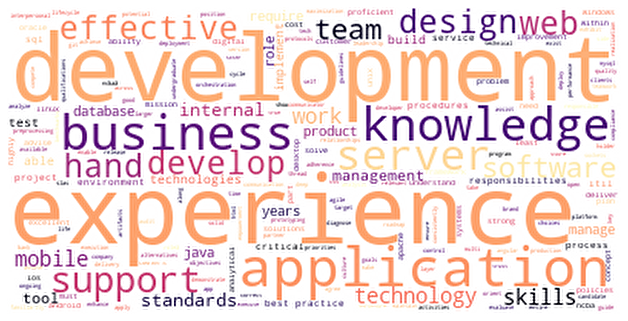

In [133]:
#Visualize

plt.figure(figsize=[11, 11])
plt.imshow(wordcloud, interpolation='sinc')
plt.axis('off')
plt.show()